In [1]:
import matplotlib.pyplot as plt
import uproot_methods

In [2]:
import uproot
import os
import numpy as np
import pandas as pd
import argparse


def decode_keys(d):
    for k in list(d.keys()):
        d[k.decode("utf-8")] = d.pop(k)
    return d


def print_df_repeated_header(df, n_repeat_header=50):
    index_width = max([len(b) for b in df.index])
    padded_index = [b + " " * (index_width - len(b)) for b in df.index]
    n_repeat_header = 30
    i = 0
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        while i < len(df):
            df_slice = df[i : i + n_repeat_header]
            df_slice.index = padded_index[i : i + n_repeat_header]
            print()
            print(df_slice)
            i += n_repeat_header

In [5]:
def very_loose_muon_id(df):

    selection_masks = [
                df["Muon_looseId"] == 1,
                df["Muon_pt"] > 10.0,
                np.abs(df["Muon_eta"]) < 2.4,
                np.abs(df["Muon_dz"]) < 0.1,
                np.abs(df["Muon_dxy"]) < 0.05,
            ]
    
    mask = True
    for s in selection_masks:
        mask = np.logical_and(mask, s)
        
    return mask


def isLooseMuonPOG(mus):
    # https://github.com/cmstas/CORE/blob/master/MuonSelections.cc
    
    # equivalent to "Muon_looseId"
    mask = np.logical_and(mus["Muon_isPFcand"], np.logical_or(mus["Muon_isGlobal"], mus["Muon_isTracker"]))

    return mask

def very_loose_electron_id(df):

    selection_masks = [
                df["Electron_pt"] > 10.0,
                np.abs(df["Electron_eta"]) < 2.5,
                np.abs(df["Electron_dz"]) < 0.1,
                np.abs(df["Electron_dxy"]) < 0.05,
            ]
    
    mask = True
    for s in selection_masks:
        mask = np.logical_and(mask, s)
        
    return mask

In [6]:
class TreeWrapper(object):
    def __init__(self, tree, table_name):
        self.tree_ = tree
    def __getitem__(self, key):
        return self.tree_.array(key)

In [7]:
def get_ele_mask(nano, data):
    ele_mask_1 = nano.array("Electron_mvaFall17V2noIso_WPL") == 1
    ele_mask_2 = very_loose_electron_id(TreeWrapper(nano, "Electron"))
    
    ele_mask = np.logical_and(ele_mask_1, ele_mask_2)
    
    data["Electron_veto_mask_noiso"] = ele_mask
    data["Electron_veto_mask"] = np.logical_and(ele_mask, data["Electron_relIso03EAv4wLep"] < 0.4)

In [8]:
def count_veto_leptons(nano, data):
    
    muon_mask_1 = isLooseMuonPOG(TreeWrapper(nano, "Muon"))
    muon_mask_2 = very_loose_muon_id(TreeWrapper(nano, "Muon"))
    muon_mask = np.logical_and(muon_mask_1, muon_mask_2)
    
    data["Muon_veto_mask_noiso"] = muon_mask
    muon_mask = np.logical_and(muon_mask, data["Muon_relIso03EAv4wLep"] < 0.4)
    data["Muon_veto_mask"] = muon_mask
    
    data["n_veto_leptons_noiso"] = data["Electron_veto_mask_noiso"].sum() + data["Muon_veto_mask_noiso"].sum()
    
    data["n_veto_leptons"] = data["Electron_veto_mask"].sum() + data["Muon_veto_mask"].sum()

In [9]:
def count_25_leptons(nano, data):
    ele_pt = nano.array("Electron_pt")
    muon_pt = nano.array("Muon_pt")
    ele_abseta = np.abs(nano.array("Electron_eta"))
    muon_abseta = np.abs(nano.array("Muon_eta"))
    data["n_10_leptons"] = np.logical_and(ele_pt > 10, ele_abseta < 2.5).sum() + \
                           np.logical_and(muon_pt > 10, muon_abseta < 2.4).sum()

    data["n_25_leptons"] = np.logical_and(ele_pt > 25, ele_abseta < 2.5).sum() + \
                           np.logical_and(muon_pt > 25, muon_abseta < 2.4).sum()

In [10]:
from geeksw.utils.core import concatenate

In [65]:
def add_isolations(nano, data):

    def rel_iso_component(leptons, pfcands):
        pairing = leptons.cross(pfcands, nested=True)
        delta_r = pairing.i0.delta_r(pairing.i1)
        in_cone = np.logical_and(delta_r < 0.3, delta_r > 0.0005)

        return (pairing.i1[in_cone].pt / pairing.i0[in_cone].pt).sum()
    
    electrons = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        nano.array("Electron_pt") / nano.array("Electron_eCorr"),
        nano.array("Electron_eta"),
        nano.array("Electron_phi"),
        nano.array("Electron_mass")
    )
    
    muons = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        nano.array("Muon_pt"),
        nano.array("Muon_eta"),
        nano.array("Muon_phi"),
        nano.array("Muon_mass")
    )
    
    pf_electrons = electrons[nano.array("Electron_isPFcand")]
    pf_muons = muons[nano.array("Muon_isPFcand")]
    
    data["Electron_relIso03EAv4"] = nano.array("Electron_pfRelIso03_all")
    data["Muon_relIso03EAv4"] = nano.array("Muon_pfRelIso03_all")
    data["Muon_miniPFRelIso_all"] = nano.array("Muon_miniPFRelIso_all")

    data["Electron_relIso03EAv4wLep"] = data["Electron_relIso03EAv4"] + \
                                   rel_iso_component(electrons, pf_electrons) + \
                                   rel_iso_component(electrons, pf_muons)
    
    data["Muon_relIso03EAv4wLep"] = data["Muon_relIso03EAv4"] + \
                                   rel_iso_component(muons, pf_electrons) + \
                                   rel_iso_component(muons, pf_muons)

In [66]:
baby_file = "WVZMVA2017_v0.1.21__wwz_4l2v_amcatnlo_1.root"
nano_dir = "/home/jonas/store/mc/RunIIFall17NanoAODv6/WWZJetsTo4L2Nu_4f_TuneCP5_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1"

nano_files = []
for root, dirs, files in os.walk(nano_dir):
    for name in files:
        if name.lower().endswith(".root"):
            nano_files.append(os.path.join(root, name))

baby = uproot.open(baby_file)["t"]
baby_event = baby.array("evt")

print(baby.array("evt_scale1fb")[0])

all_branches = list(set([br.decode("utf-8") for br in baby.keys()]))

nanos = [uproot.open(nano)["Events"] for nano in nano_files]

    
is_data = False
lumi = 0.0

converters = {
    "run": lambda nano: nano.array("run"),
    "lumi": lambda nano: nano.array("luminosityBlock"),
    "evt": lambda nano: nano.array("event"),
    "isData": lambda nano: np.zeros(len(nano), dtype=np.bool) | is_data,
    "evt_passgoodrunlist": lambda nano: np.ones(len(nano), dtype=np.bool),
    "evt_firstgoodvertex": lambda nano: np.ones(len(nano), dtype=np.int),
    "nvtx": lambda nano: nano.array("PV_npvsGood"),
    "nTrueInt": lambda nano: np.zeros(len(nano), dtype=np.int) - 999 if is_data else nano.array("Pileup_nTrueInt"),
    "passesMETfiltersRun2": lambda nano: nano.array("Flag_METFilters"),
    "met_gen_pt": lambda nano: np.zeros(len(nano), dtype=np.float) - 9999.0 if is_data else nano.array("GenMET_pt"),
    "met_gen_phi": lambda nano: np.zeros(len(nano), dtype=np.float) - 9999.0 if is_data else nano.array("GenMET_phi"),
    "hasTau": lambda nano: nano.array("nTau") > 0,
    "Electron_pt": lambda nano: nano.array("Electron_pt"),
    "Electron_pt_orig": lambda nano: nano.array("Electron_pt") / nano.array("Electron_eCorr"),
    "Electron_eta": lambda nano: nano.array("Electron_eta"),
    "nElectron": lambda nano: nano.array("nElectron"),
    "Muon_pt": lambda nano: nano.array("Muon_pt"),
    "Muon_eta": lambda nano: nano.array("Muon_eta"),
    "nMuon": lambda nano: nano.array("nMuon"),
    "firstgoodvertex": lambda nano: np.zeros(len(nano), dtype=np.int),
    "lumi": lambda nano: np.zeros(len(nano), dtype=np.float) + lumi,
    "evt_scale1fb": lambda nano: np.ones(len(nano), dtype=np.float),
    "evt_scale1fb": lambda nano: np.ones(len(nano), dtype=np.float),
    "xsec_br": lambda nano: np.ones(len(nano), dtype=np.float),
}

datas = []
for nano_file in nano_files:
    nano = uproot.open(nano_file)["Events"]
    
    datas.append(dict())
    
    for column, func in converters.items():
        datas[-1][column] = func(nano)
        
    add_isolations(nano, datas[-1])
    get_ele_mask(nano, datas[-1])
    count_veto_leptons(nano, datas[-1])
    count_25_leptons(nano, datas[-1])
        
data_full = dict()
for column in datas[-1].keys():
    data_full[column] = concatenate([d[column] for d in datas])

-3.497364e-07


In [67]:
def skim(data):
    
    skim_mask = np.logical_and.reduce([
        data["n_10_leptons"] >= 4,
        data["n_25_leptons"] >= 2,
        data["n_veto_leptons_noiso"] >= 4,
        data["n_veto_leptons"] >= 2,
    ])
    
    data_skimmed = dict()
    for column, array in data.items():
        
        data_skimmed[column] = array[skim_mask]
    
    return data_skimmed

data = skim(data_full)

nano_event = data["evt"]

n_overlap = np.sum(np.in1d(nano_event, baby_event))
n_nano = len(nano_event)
n_baby = len(baby_event)

print()
print("Overlapping events:", n_overlap)
print("Events only in nano:", n_nano - n_overlap)
print("Events only in baby:", n_baby - n_overlap)
print()

_, nano_idx, baby_idx = np.intersect1d(nano_event, baby_event, return_indices=True)


Overlapping events: 872932
Events only in nano: 1538
Events only in baby: 1036



In [68]:
def kinematics_comparison_plot(baby_variable="lep_pt",
                               nano_variable="pt",
                               bins=np.linspace(0,200,200),
                               particle="Electron"):
        
    assert(particle in ["Electron", "Muon"])

    lep_id = 11 if particle == "Electron" else 13

    electron_mask = np.abs(baby.array("lep_id")) == lep_id
    
    baby_values = baby.array(baby_variable)[electron_mask]
    baby_events = baby.array("evt")
    idx = baby_values.counts.argmax()
    label = particle + " " + baby_variable

    ele_mask = data[particle + "_veto_mask_noiso"]
    nano_values = data[particle + "_" + nano_variable][ele_mask]
    print(label)
    print("=" * len(label))
    print(f"Values in event {baby_events[idx]} (the exent with the most objects)")
    print("baby: ", baby_values[idx])
    print("nano: ", nano_values[np.argmax(data["evt"] == baby_events[idx])])

    plt.hist(baby_values.flatten(), bins, histtype="step", label="BABY")
    plt.hist(nano_values.flatten(), bins, histtype="step", label="NANO")

    plt.legend(loc="upper right")
    #plt.gca().set_yscale("log", nonposy='clip')
    plt.xlabel(label)
    plt.ylabel("Events")
    #plt.savefig(particle + "_" + baby_variable + ".png", dpi=300)
    plt.show()

Electron lep_pt
Values in event 1567918 (the exent with the most objects)
baby:  [195.77493   99.263306  59.494865  54.603233  32.166115  18.038237]
nano:  [195.77492   99.2633    59.494873  54.603233  32.166115  18.038237]


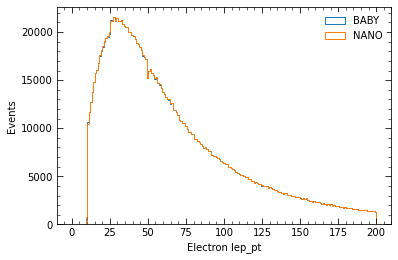

Electron lep_eta
Values in event 1567918 (the exent with the most objects)
baby:  [ 2.0434613  1.1090504  1.1678052  1.9221052  2.367174  -1.1214471]
nano:  [ 2.043457   1.1091309  1.1677246  1.9221191  2.3671875 -1.1213379]


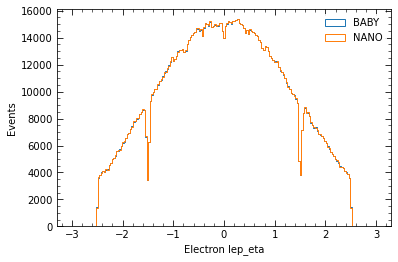

Muon lep_pt
Values in event 1995305 (the exent with the most objects)
baby:  [95.35774  59.53778  58.98919  29.124556 25.567905 12.981443]
nano:  [95.35775  59.53778  58.989193 29.124556 25.567905 12.981444]


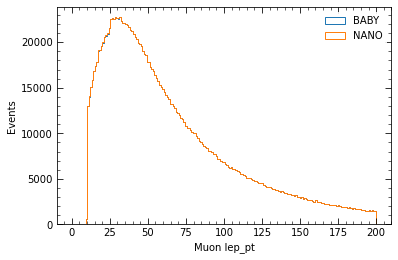

Muon lep_eta
Values in event 1995305 (the exent with the most objects)
baby:  [0.6956149 1.7361822 0.5018749 2.2940435 2.319182  0.5227505]
nano:  [0.69555664 1.736084   0.50183105 2.2939453  2.319336   0.5227051 ]


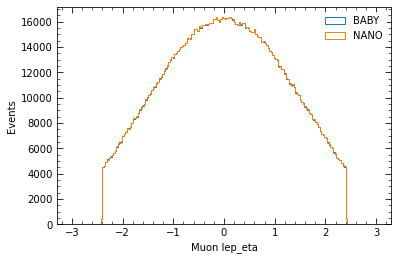

In [69]:
pt_bins = np.linspace(0,200,200)
eta_bins = np.linspace(-3, 3,200)

kinematics_comparison_plot("lep_pt", "pt_orig", pt_bins, "Electron")
kinematics_comparison_plot("lep_eta", "eta", eta_bins, "Electron")
kinematics_comparison_plot("lep_pt", "pt", pt_bins, "Muon")
kinematics_comparison_plot("lep_eta", "eta", eta_bins, "Muon")

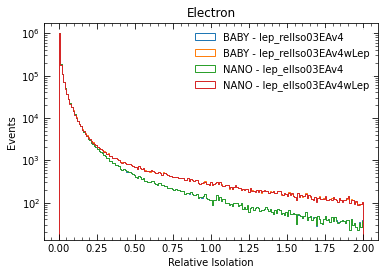

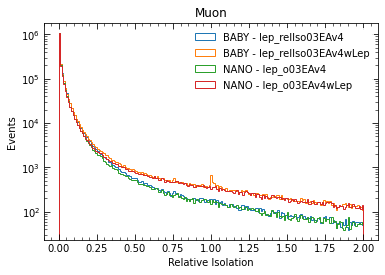

In [70]:
for particle in ["Electron", "Muon"]:
    
    lep_id = 11 if particle == "Electron" else 13

    electron_mask = np.abs(baby.array("lep_id")) == lep_id
    bins = np.linspace(0,2,200)

    baby_pt = baby.array("lep_pt")[electron_mask].flatten()

    for var in ["lep_relIso03EAv4", "lep_relIso03EAv4wLep"]:
        plt.hist(baby.array(var)[electron_mask].flatten(),# * baby_pt,
                 bins, histtype="step",
                 label="BABY - " + var)

    ele_mask = data[particle + "_veto_mask_noiso"]
    for var in [particle + "_relIso03EAv4", particle + "_relIso03EAv4wLep"]:
        plt.hist(data[var][ele_mask].flatten(),# * data[particle + "_pt"][ele_mask][nano_idx].flatten(),
                 bins, histtype="step",
                 label="NANO - lep_" + var[10:])

    plt.legend(loc="upper right")
    plt.gca().set_yscale("log", nonposy='clip')
    plt.title(particle)
    plt.xlabel("Relative Isolation")
    plt.ylabel("Events")
    plt.savefig(particle+"_isolation.png", dpi=300)
    plt.show()

In [71]:
nano.keys()

[b'run',
 b'luminosityBlock',
 b'event',
 b'HTXS_Higgs_pt',
 b'HTXS_Higgs_y',
 b'HTXS_stage1_1_cat_pTjet25GeV',
 b'HTXS_stage1_1_cat_pTjet30GeV',
 b'HTXS_stage1_1_fine_cat_pTjet25GeV',
 b'HTXS_stage1_1_fine_cat_pTjet30GeV',
 b'HTXS_stage_0',
 b'HTXS_stage_1_pTjet25',
 b'HTXS_stage_1_pTjet30',
 b'HTXS_njets25',
 b'HTXS_njets30',
 b'btagWeight_CSVV2',
 b'btagWeight_DeepCSVB',
 b'CaloMET_phi',
 b'CaloMET_pt',
 b'CaloMET_sumEt',
 b'ChsMET_phi',
 b'ChsMET_pt',
 b'ChsMET_sumEt',
 b'nCorrT1METJet',
 b'CorrT1METJet_area',
 b'CorrT1METJet_eta',
 b'CorrT1METJet_muonSubtrFactor',
 b'CorrT1METJet_phi',
 b'CorrT1METJet_rawPt',
 b'nElectron',
 b'Electron_deltaEtaSC',
 b'Electron_dr03EcalRecHitSumEt',
 b'Electron_dr03HcalDepth1TowerSumEt',
 b'Electron_dr03TkSumPt',
 b'Electron_dr03TkSumPtHEEP',
 b'Electron_dxy',
 b'Electron_dxyErr',
 b'Electron_dz',
 b'Electron_dzErr',
 b'Electron_eCorr',
 b'Electron_eInvMinusPInv',
 b'Electron_energyErr',
 b'Electron_eta',
 b'Electron_hoe',
 b'Electron_ip3d',
 b'Ele

In [72]:
df_info = pd.DataFrame(index=sorted(all_branches))

for branch in all_branches:
    if not branch in converters:
        continue

    #tgt = np.concatenate([converters[branch](nano)[nano_idx] for nano, nano_idx in zip(nanos, nano_indices)])
    #nano_index = b
    tgt = data[branch][nano_idx]
    ref = baby.array(branch)[baby_idx]

    df_info.loc[branch, "exact match [%]"] = (tgt == ref).sum() * 100.0 / len(tgt)
    df_info.loc[branch, "float match [%]"] = np.abs(((tgt - ref) / ref) < 1e-6).sum() * 100.0 / len(tgt)
    df_info.loc[branch, "bias [tgt - ref]"] = np.mean(tgt - ref)

#print_df_repeated_header(df_info)

<ipython-input-72-471a90544d57>:13: RuntimeWarning: invalid value encountered in true_divide
  df_info.loc[branch, "float match [%]"] = np.abs(((tgt - ref) / ref) < 1e-6).sum() * 100.0 / len(tgt)
<ipython-input-72-471a90544d57>:13: RuntimeWarning: invalid value encountered in less
  df_info.loc[branch, "float match [%]"] = np.abs(((tgt - ref) / ref) < 1e-6).sum() * 100.0 / len(tgt)
<ipython-input-72-471a90544d57>:13: RuntimeWarning: divide by zero encountered in true_divide
  df_info.loc[branch, "float match [%]"] = np.abs(((tgt - ref) / ref) < 1e-6).sum() * 100.0 / len(tgt)


In [73]:
df_info.dropna()

,exact match [%],float match [%],bias [tgt - ref]
evt,100.000000,100.000000,0.000000e+00
evt_passgoodrunlist,100.000000,100.000000,0.000000e+00
evt_scale1fb,0.000000,5.813740,9.999997e-01
firstgoodvertex,99.950855,0.049145,-4.925928e-04
hasTau,1.028488,1.027571,9.897151e-01
isData,100.000000,0.000000,0.000000e+00
lumi,0.000000,100.000000,-2.001340e+03
met_gen_phi,0.011456,50.215137,-8.625369e-08
met_gen_pt,0.013518,50.180656,-3.872479e-05
nTrueInt,100.000000,99.996678,0.000000e+00


In [74]:
baby.array("lep_pt")

<JaggedArray [[87.86332 84.658226 49.706894 25.335981] [66.51936 37.998196 33.62712 15.043882] [137.16824 136.08716 125.12341 27.392124] ... [75.53534 70.00876 47.60255 42.994022] [284.14337 279.74268 55.885025 31.310638] [106.2479 34.376465 24.01683 11.655056]] at 0x7fa709110610>